In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pprint import pprint
from skimage.io import imread
import utils
import torch
from torch import nn
import torchvision
from torchvision.transforms import ToTensor
print(f'Pytorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')


Pytorch version: 2.0.0+cpu, Torchvision version: 0.15.1+cpu


In [3]:
path=glob.glob(os.path.join('MURA-v1.1','*','*','*', '*','*.png'))
pprint(path)


['MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient0

We try to concatenate all the info about the images in one dataset
We use the character '\\' because one '\' is the escape and the other separates the subfolders in our OS (Windows). if we worked in linux we would use the character '/'
THere are two studies :study 1 and study 2

In [4]:
everythingScans_df=pd.DataFrame(dict(path=path))
everythingScans_df['Split']=everythingScans_df['path'].map(lambda x:x.split('\\')[1])
everythingScans_df['Bone']=everythingScans_df['path'].map(lambda x:x.split('\\')[2])
everythingScans_df['Patient']=everythingScans_df['path'].map(lambda x:x.split('\\')[3])
everythingScans_df['FolderName']=everythingScans_df['path'].map(lambda x:x.split('\\')[4])
everythingScans_df['Study']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[0])
everythingScans_df['Label']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[1])
everythingScans_df.sample(10)

path  Split         Bone  \
9594   MURA-v1.1\train\XR_FINGER\patient04718\study1_...  train    XR_FINGER   
10344  MURA-v1.1\train\XR_FOREARM\patient05707\study1...  train   XR_FOREARM   
36993  MURA-v1.1\valid\XR_ELBOW\patient11764\study1_p...  valid     XR_ELBOW   
6731   MURA-v1.1\train\XR_FINGER\patient03633\study1_...  train    XR_FINGER   
3476   MURA-v1.1\train\XR_ELBOW\patient05824\study1_n...  train     XR_ELBOW   
39668  MURA-v1.1\valid\XR_WRIST\patient11273\study1_p...  valid     XR_WRIST   
23125  MURA-v1.1\train\XR_SHOULDER\patient01448\study...  train  XR_SHOULDER   
27959  MURA-v1.1\train\XR_WRIST\patient03050\study1_p...  train     XR_WRIST   
18542  MURA-v1.1\train\XR_HUMERUS\patient03159\study1...  train   XR_HUMERUS   
28564  MURA-v1.1\train\XR_WRIST\patient05430\study2_n...  train     XR_WRIST   

            Patient       FolderName   Study     Label  
9594   patient04718  study1_negative  study1  negative  
10344  patient05707  study1_negative  study1  negative  
36993  patient11764  study1_positive  study1  positive  
6731   patient03633  study1_positive  study1  positive  
3476   patient05824  study1_negative  study1  negative  
39668  patient11273  study1_positive  study1  positive  
23125  patient01448  study2_negative  study2  negative  
27959  patient03050  study1_positive  study1  positive  
18542  patient03159  study1_negative  study1  negative  
28564  patient05430  study2_negative  study2  negative

We check if some data is missing

In [5]:
print(everythingScans_df.isnull().values.any())
a=[0 if (x=='positive' or x=='negative') else 1 for x in everythingScans_df['Label'] ]
print(sum(a))

False
0


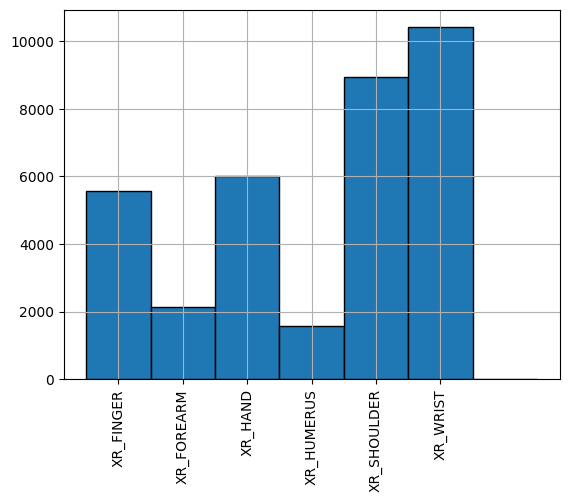

In [15]:

everythingScans_df['Bone'].hist(bins=range(1,9),rwidth=1, align='left',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

# Explore some examples of images
When groupping by two values we need to define how the values will be combined.
get combinations of pics with same label and bone then choose one randomly 

In [7]:
onePairPic_df=everythingScans_df.groupby(['Label','Bone']).apply(lambda x:x.sample(1))
onePairPic_df.reset_index(drop=True)

path  Split         Bone  \
0   MURA-v1.1\train\XR_ELBOW\patient05911\study1_n...  train     XR_ELBOW   
1   MURA-v1.1\train\XR_FINGER\patient04100\study1_...  train    XR_FINGER   
2   MURA-v1.1\train\XR_FOREARM\patient00253\study1...  train   XR_FOREARM   
3   MURA-v1.1\train\XR_HAND\patient08292\study1_ne...  train      XR_HAND   
4   MURA-v1.1\train\XR_HUMERUS\patient03018\study1...  train   XR_HUMERUS   
5   MURA-v1.1\train\XR_SHOULDER\patient02564\study...  train  XR_SHOULDER   
6   MURA-v1.1\train\XR_WRIST\patient00508\study1_n...  train     XR_WRIST   
7   MURA-v1.1\train\XR_ELBOW\patient03077\study1_p...  train     XR_ELBOW   
8   MURA-v1.1\train\XR_FINGER\patient03438\study1_...  train    XR_FINGER   
9   MURA-v1.1\train\XR_FOREARM\patient09184\study1...  train   XR_FOREARM   
10  MURA-v1.1\valid\XR_HAND\patient11382\study1_po...  valid      XR_HAND   
11  MURA-v1.1\train\XR_HUMERUS\patient02747\study1...  train   XR_HUMERUS   
12  MURA-v1.1\train\XR_SHOULDER\patient00887\study...  train  XR_SHOULDER   
13  MURA-v1.1\train\XR_WRIST\patient03215\study1_p...  train     XR_WRIST   

         Patient       FolderName   Study     Label  
0   patient05911  study1_negative  study1  negative  
1   patient04100  study1_negative  study1  negative  
2   patient00253  study1_negative  study1  negative  
3   patient08292  study1_negative  study1  negative  
4   patient03018  study1_negative  study1  negative  
5   patient02564  study1_negative  study1  negative  
6   patient00508  study1_negative  study1  negative  
7   patient03077  study1_positive  study1  positive  
8   patient03438  study1_positive  study1  positive  
9   patient09184  study1_positive  study1  positive  
10  patient11382  study1_positive  study1  positive  
11  patient02747  study1_positive  study1  positive  
12  patient00887  study1_positive  study1  positive  
13  patient03215  study1_positive  study1  positive

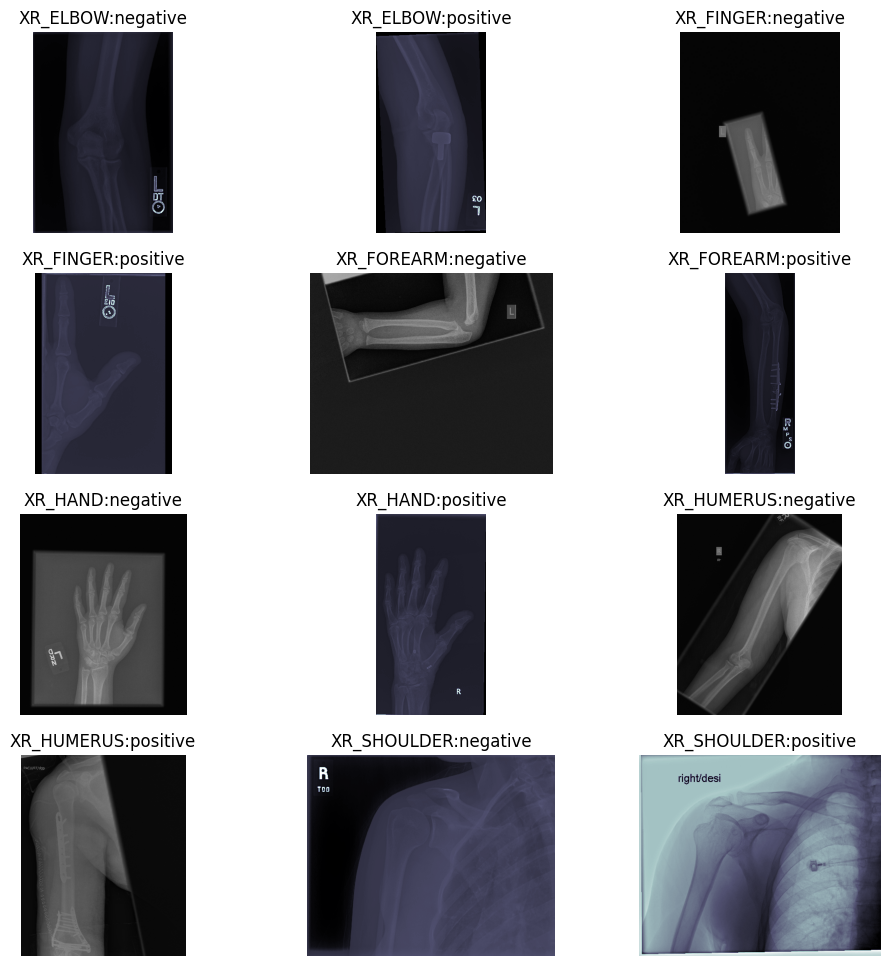

In [9]:
sub_df = everythingScans_df.groupby(['Bone', 'Label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Bone}:{Label}'.format(**c_row))

In [30]:
# try working only on humerus

humerus_df=everythingScans_df.loc[everythingScans_df['Bone']=='XR_HUMERUS'].copy()
humerus_df.sample(10)

path  Split        Bone  \
18665  MURA-v1.1\train\XR_HUMERUS\patient03220\study1...  train  XR_HUMERUS   
17663  MURA-v1.1\train\XR_HUMERUS\patient02756\study1...  train  XR_HUMERUS   
17462  MURA-v1.1\train\XR_HUMERUS\patient01464\study1...  train  XR_HUMERUS   
18180  MURA-v1.1\train\XR_HUMERUS\patient02990\study1...  train  XR_HUMERUS   
38652  MURA-v1.1\valid\XR_HUMERUS\patient11646\study1...  valid  XR_HUMERUS   
38514  MURA-v1.1\valid\XR_HUMERUS\patient11251\study1...  valid  XR_HUMERUS   
17417  MURA-v1.1\train\XR_HUMERUS\patient00246\study1...  train  XR_HUMERUS   
17604  MURA-v1.1\train\XR_HUMERUS\patient02729\study1...  train  XR_HUMERUS   
17510  MURA-v1.1\train\XR_HUMERUS\patient02419\study1...  train  XR_HUMERUS   
18617  MURA-v1.1\train\XR_HUMERUS\patient03195\study1...  train  XR_HUMERUS   

            Patient       FolderName   Study     Label  
18665  patient03220  study1_negative  study1  negative  
17663  patient02756  study1_positive  study1  positive  
17462  patient01464  study1_positive  study1  positive  
18180  patient02990  study1_negative  study1  negative  
38652  patient11646  study1_positive  study1  positive  
38514  patient11251  study1_negative  study1  negative  
17417  patient00246  study1_negative  study1  negative  
17604  patient02729  study1_positive  study1  positive  
17510  patient02419  study1_positive  study1  positive  
18617  patient03195  study1_negative  study1  negative

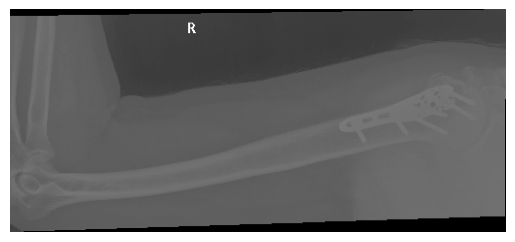

In [52]:
show_image(imread(humerus_df['path'].iloc[0]))

In [36]:
from torch.utils.data import Dataset, DataLoader

class HumerusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = self.df['Label'].map({'positive': 1, 'negative': 0})
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = imread(self.df['path'].iloc[idx])
        if self.transform:
            img = self.transform(img)
        return img, self.labels.iloc[idx]

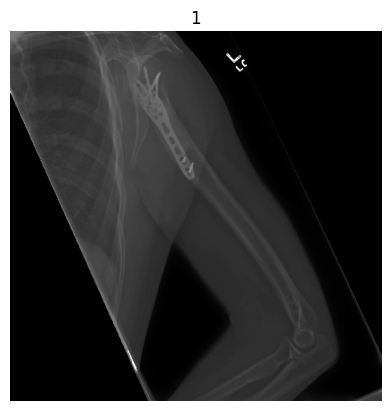

In [54]:
img,label=HumerusDataset(humerus_df)[18]
utils.show_image_w_label(img,label)